In [1]:
import time
import nltk
from nltk.corpus import stopwords

#NLP
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
import string, re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Data Prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

#Machine Learning
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# XGBoost
from xgboost import XGBRegressor
from xgboost import XGBClassifier


#Save Model
import pickle

import matplotlib.pyplot as plt

# import tdqm
from tqdm import tqdm


from pprint import pprint
import time
import logging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

In [2]:
data_df = pd.read_csv('processing/data_df_V2.csv')

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7051 entries, 0 to 7050
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          7051 non-null   object 
 1   Salary Estimate    7051 non-null   object 
 2   Job Description    7051 non-null   object 
 3   Rating             6241 non-null   float64
 4   Company Name       7051 non-null   object 
 5   Location           7025 non-null   object 
 6   Size               5532 non-null   object 
 7   Founded            4653 non-null   float64
 8   Type of ownership  5974 non-null   object 
 9   Industry           5474 non-null   object 
 10  Sector             5474 non-null   object 
 11  Revenue            3847 non-null   object 
 12  City               7025 non-null   object 
 13  State              6566 non-null   object 
 14  Salary Min         7051 non-null   float64
 15  Salary Max         7051 non-null   float64
 16  Revenue Index      3847 

In [5]:
# add average salary
data_df['Average Salary'] = (data_df['Salary Min'] + data_df['Salary Max']) / 2
# add age of company
data_df['Age of company'] = time.localtime().tm_year - data_df['Founded']

In [6]:
# create salary bins
BINS = [0,50000,70000,90000,120000,150000,200000,500000]
# LABELS = ['0-50k','50-70k','70-90k','90-120k','120-150k','150-200k','200k+']
data_df['Salary Range'] = pd.cut(data_df['Average Salary'], bins=BINS, labels=False)

In [6]:
data_df['Salary Range'].value_counts()

3    1997
2    1172
4    1134
1     883
5     873
0     541
6     451
Name: Salary Range, dtype: int64

In [7]:
target_data = data_df['Salary Range'].astype('category')

In [8]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stopwords_list += ['www','http','com','llc','covid','non','pm','am','eg','e','g','ie','i']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)

    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [9]:
data_df['Cleaned Job Description'] = clean_word(data_df['Job Description'])

In [10]:
data_df['Cleaned Job Title'] = clean_word(data_df['Job Title'])

In [11]:
Training_data = data_df[['Cleaned Job Description','Cleaned Job Title','Revenue','Size','Age of company', 'Rating']]

In [12]:
# # get dummy data for categorical variables
Training_data = pd.get_dummies(Training_data, columns=['Revenue','Size'])

In [13]:
# fill missing values in age of company and rating
Training_data['Age of company'].fillna(np.random.normal(Training_data['Age of company'].mean(), Training_data['Age of company'].std()), inplace=True)
Training_data['Rating'].fillna(np.random.normal(Training_data['Rating'].mean(), Training_data['Rating'].std()), inplace=True)

In [14]:

X_train, X_test, y_train, y_test = train_test_split(Training_data, target_data, test_size=0.15, random_state=0)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5993 entries, 2920 to 2732
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Cleaned Job Description                   5993 non-null   object 
 1   Cleaned Job Title                         5993 non-null   object 
 2   Age of company                            5993 non-null   float64
 3   Rating                                    5993 non-null   float64
 4   Revenue_$1 to $5 billion (USD)            5993 non-null   uint8  
 5   Revenue_$1 to $5 million (USD)            5993 non-null   uint8  
 6   Revenue_$10+ billion (USD)                5993 non-null   uint8  
 7   Revenue_$100 to $500 million (USD)        5993 non-null   uint8  
 8   Revenue_$25 to $100 million (USD)         5993 non-null   uint8  
 9   Revenue_$5 to $10 billion (USD)           5993 non-null   uint8  
 10  Revenue_$5 to $25 million (USD)  

Model 1: Use Word2Vec Embedding in Classification Models

In [16]:
# Model 1: Use Word2Vec Embedding in Classification Models

# Create Word2Vec Model
w2v_model_description = Word2Vec(X_train['Cleaned Job Description'], vector_size=64, window=5, min_count=1, workers=4)
w2v_model_title = Word2Vec(X_train['Cleaned Job Title'], vector_size=32, window=3, min_count=1, workers=4)

# Create Average Word Embedding
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# Create Average Word Embedding for Training and Test Data
avg_wv_train_description = averaged_word_vectorizer(corpus=X_train['Cleaned Job Description'], model=w2v_model_description, num_features=64)
avg_wv_test_description = averaged_word_vectorizer(corpus=X_test['Cleaned Job Description'], model=w2v_model_description, num_features=64)

avg_wv_train_title = averaged_word_vectorizer(corpus=X_train['Cleaned Job Title'], model=w2v_model_title, num_features=32)
avg_wv_test_title = averaged_word_vectorizer(corpus=X_test['Cleaned Job Title'], model=w2v_model_title, num_features=32)

# Create Training and Test Data
X_train_w2v = np.concatenate((avg_wv_train_description, avg_wv_train_title, X_train.iloc[:,2:].values), axis=1)
X_test_w2v = np.concatenate((avg_wv_test_description, avg_wv_test_title, X_test.iloc[:,2:].values), axis=1)

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=64, random_state=0)
rfc.fit(X_train_w2v, y_train)
y_pred = rfc.predict(X_test_w2v)
print('Random Forest Classifier')
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

# # Gradient Boosting Classifier
# gbc = GradientBoostingClassifier(n_estimators=200, random_state=0)
# gbc.fit(X_train_w2v, y_train)
# y_pred = gbc.predict(X_test_w2v)
# print('Accuracy Score: ', accuracy_score(y_test, y_pred))
# print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

# Support Vector Classifier
# svc = SVC(kernel='linear', random_state=0)
# svc.fit(X_train_w2v, y_train)
# y_pred = svc.predict(X_test_w2v)
# print('Support Vector Classifier')
# print('Accuracy Score: ', accuracy_score(y_test, y_pred))

# Stockastic Gradient Descent Classifier
sgdc = SGDClassifier(random_state=0)
sgdc.fit(X_train_w2v, y_train)
y_pred = sgdc.predict(X_test_w2v)
print('Stockastic Gradient Descent Classifier')
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))


Random Forest Classifier
Accuracy Score:  0.5368620037807184
F1 Score:  0.52942325814835
Stockastic Gradient Descent Classifier
Accuracy Score:  0.29773156899810965
F1 Score:  0.22409492918220852


In [17]:
# # Random Forest Classifier is more accurate and has a higher F1 score than other models.
# #  ==> Worthy to do some grid search.

# # Random Forest with Grid Search

# # Create Pipeline
# pipe = Pipeline([('classifier' , RandomForestClassifier())])
# # Create param grid.
# param_grid = [
#     {'classifier' : [RandomForestClassifier()],
#      'classifier__n_estimators' : [100, 300, 500],
#      'classifier__max_features' : ['auto', 'sqrt', 'log2'],
#      'classifier__max_depth' : [10, 20, 50],
#      'classifier__criterion' : ['gini', 'entropy']}
# ]
# # Create grid search object
# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
# # Fit on data
# best_clf = clf.fit(X_train_w2v, y_train)
# # Best accuracy
# print('Best Accuracy:', best_clf.best_score_)
# # Best params
# print('Best Params:', best_clf.best_params_)
# # Predict target vector
# y_pred = best_clf.predict(X_test_w2v)
# # Check accuracy score
# print('Accuracy Score: ', accuracy_score(y_test, y_pred))
# # Check F1 score
# print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

In [18]:
# # SGD Classifier in the pipeline
# pipe = Pipeline([('classifier' , SGDClassifier())])
# # Create param grid.
# param_grid = [
#     {'classifier' : [SGDClassifier()],
#      'classifier__loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#      'classifier__penalty' : ['l2', 'l1', 'elasticnet'],
#      'classifier__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
# ]
# # Create grid search object
# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
# # Fit on data
# best_clf = clf.fit(X_train_w2v, y_train)
# # Best accuracy
# print('Best Accuracy:', best_clf.best_score_)
# # Best params
# print('Best Params:', best_clf.best_params_)
# # Predict target vector
# y_pred = best_clf.predict(X_test_w2v)
# # Check accuracy score
# print('Accuracy Score: ', accuracy_score(y_test, y_pred))
# # Check F1 score
# print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

    

Best Accuracy: 0.3645938996406286

Best Params: {'clf__alpha': 0.0001, 'clf__l1_ratio': 0.1, 'clf__max_iter': 100, 'clf__penalty': 'l2'}

Accuracy Score:  0.10586011342155009

F1 Score:  0.056503397601535374

<font color = green size = 10>model 2: Use TF-IDF in Classification Models</font>

In [12]:
from pprint import pprint
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [20]:
Train_data_2 = data_df[['Job Description','Job Title','Revenue','Size','Age of company', 'Rating']]

Train_data_2 = pd.get_dummies(Train_data_2, columns=['Revenue','Size'])

Train_data_2['Rating'] = Train_data_2['Rating'].astype('float', errors='ignore')

# fill missing values in age of company and rating with gaussian distribution
Train_data_2['Age of company'].fillna(np.random.normal(Train_data_2['Age of company'].mean(), Train_data_2['Age of company'].std()), inplace=True)
Train_data_2['Rating'].fillna(np.random.normal(Train_data_2['Rating'].mean(), Train_data_2['Rating'].std()), inplace=True)




In [21]:
# model 2: Use TF-IDF in Classification Models


X_train_model2, X_test_model2, y_train_model2, y_test_model2 = train_test_split(Train_data_2, target_data, test_size=0.15, random_state=0)

# add TF-IDF for job description and job title then concatenate with other features
tfidf = Pipeline([('vect', CountVectorizer(max_df=0.5, min_df=0.005, ngram_range=(1,3), stop_words='english')),
                ('tfidf', TfidfTransformer(smooth_idf=False, use_idf=False))])

X_train_tfidf = tfidf.fit_transform(X_train_model2['Job Description']) 
X_test_tfidf = tfidf.transform(X_test_model2['Job Description'])

X_train_tfidf_title = tfidf.fit_transform(X_train_model2['Job Title'])
X_test_tfidf_title = tfidf.transform(X_test_model2['Job Title'])



In [22]:
test = np.concatenate((X_train_tfidf.toarray(), X_train_tfidf_title.toarray(), X_train.iloc[:,2:].values), axis=1)
test.shape

(5993, 15347)

In [23]:
X_train_tfidf.shape

(5993, 15162)

In [24]:

X_train_full_model2 = np.concatenate((X_train_tfidf.toarray(), X_train_tfidf_title.toarray(), X_train.iloc[:,2:].values), axis=1)
X_test_full_model2= np.concatenate((X_test_tfidf.toarray(), X_test_tfidf_title.toarray(), X_test.iloc[:,2:].values), axis=1)

# X_train_full_model2 = X_train_tfidf
# X_test_full_model2 = X_test_tfidf


# Random Forest Classifier
rfc = RandomForestClassifier(criterion='gini', max_features='sqrt', n_estimators=100, min_samples_split=10, max_depth=100, random_state=0)
rfc.fit(X_train_full_model2, y_train)
y_pred = rfc.predict(X_test_full_model2)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))


# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_full_model2, y_train)
y_pred = xgb.predict(X_test_full_model2)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

# # Support Vector Classifier
# svc = SVC(kernel='linear', random_state=0)
# svc.fit(X_train_tfidf, y_train)
# y_pred = svc.predict(X_test_tfidf)
# print('Accuracy Score: ', accuracy_score(y_test, y_pred))

# Stockastic Gradient Descent Classifier
sgdc = SGDClassifier(alpha=0.001, max_iter=500, n_jobs=3)
sgdc.fit(X_train_full_model2, y_train)
y_pred = sgdc.predict(X_test_full_model2)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

Accuracy Score:  0.5472589792060492
F1 Score:  0.5308173013802016
Accuracy Score:  0.5359168241965974
F1 Score:  0.5317144742367517
Accuracy Score:  0.3487712665406427
F1 Score:  0.24401876931537228


In [25]:
# pd.Series(rfc.feature_importances_).plot(kind='barh', figsize=(15,10))

In [26]:
# SGD Classifier in the pipeline
SGD = Pipeline([
    ('vect', CountVectorizer(max_df=0.1, min_df=0.0001, ngram_range=(1,3), stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(alpha=0.0001, max_iter=1000, n_jobs=3, loss='log_loss'))
])

# train is job title + job description
classifier = SGD.fit(X_train_model2['Job Title'] + ' ' + X_train_model2['Job Description'], y_train_model2)
y_pred = SGD.predict(X_test_model2['Job Title'] + ' ' + X_test_model2['Job Description'])
print('Accuracy Score: ', accuracy_score(y_test_model2, y_pred))
print('F1 Score: ', f1_score(y_test_model2, y_pred, average='weighted'))

Accuracy Score:  0.5236294896030246
F1 Score:  0.5052737763623761


In [27]:
SGD.score(X_test_model2['Job Description'], y_test_model2)

0.5198487712665406

<font color = green size = 10>Model 3: Use Pretrained GloVe Model</font>

In [28]:
total_words = set(word for job_description in data_df['Cleaned Job Description'] for word in job_description)

In [29]:
total_words.update(set(word for job_title in data_df['Cleaned Job Title'] for word in job_title))

In [30]:
max_length=len(total_words)
print(max_length)

46289


In [31]:
# Model 3: Use Pre-trained GloVe Embedding in Classification Models

# Create GloVe Embedding
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [32]:
# Create Embedding Matrix
embedding_matrix = np.zeros((max_length, 100))
for i, word in enumerate(total_words):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_index))])

    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [34]:
Train_data3 = data_df[['Cleaned Job Description','Cleaned Job Title','Revenue','Size','Age of company', 'Rating']]
Train_data3 = pd.get_dummies(Train_data3, columns=['Revenue','Size'])

Train_data3['Rating'] = Train_data3['Rating'].astype('float', errors='ignore')
# fill missing values in age of company and rating
Train_data3['Age of company'].fillna(np.random.normal(Train_data3['Age of company'].mean(), Train_data3['Age of company'].std()), inplace=True)
Train_data3['Rating'].fillna(np.random.normal(Train_data3['Rating'].mean(), Train_data3['Rating'].std()), inplace=True)

In [35]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(Train_data3, target_data, test_size=0.15, random_state=0)

In [36]:
w2v_glove = W2vVectorizer(embeddings_index)
x_train_description = w2v_glove.transform(X_train_3['Cleaned Job Description'])
x_test_description = w2v_glove.transform(X_test_3['Cleaned Job Description'])

x_train_title = w2v_glove.transform(X_train_3['Cleaned Job Title'])
x_test_title = w2v_glove.transform(X_test_3['Cleaned Job Title'])

x_train_glove = np.concatenate((x_train_description, x_train_title, X_train_3.iloc[:,2:].values), axis=1)
x_test_glove = np.concatenate((x_test_description, x_test_title, X_test_3.iloc[:,2:].values), axis=1)

# x_train_glove = np.concatenate((x_train_description, x_train_title), axis=1)
# x_test_glove = np.concatenate((x_test_description, x_test_title), axis=1)

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(x_train_glove, y_train_3)
y_pred = rfc.predict(x_test_glove)
print('Accuracy Score: ', accuracy_score(y_test_3, y_pred)) 
print('F1 Score: ', f1_score(y_test_3, y_pred, average='weighted'))

print('**********************************************************')
# Stockastic Gradient Descent Classifier
sgdc = SGDClassifier(random_state=0, alpha= 0.0001)
sgdc.fit(x_train_glove, y_train_3)
y_pred = sgdc.predict(x_test_glove)
print('Accuracy Score: ', accuracy_score(y_test_3, y_pred))
print('F1 Score: ', f1_score(y_test_3, y_pred, average='weighted'))



Accuracy Score:  0.5434782608695652
F1 Score:  0.5325475114642085
**********************************************************
Accuracy Score:  0.1994328922495274
F1 Score:  0.19655635067369134


<font size = 10 color = green>Model 4: Deep Learning Models with Word Embeddings</font>

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D

from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import sequence
from keras.layers import Flatten

from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

import matplotlib.pyplot as plt

In [8]:
Train_model4 = data_df[['Job Description','Job Title','Revenue','Size','Age of company', 'Rating']]

In [9]:
Train_model4_processed = pd.get_dummies(Train_model4, columns=['Revenue','Size'])

In [10]:
# fill nan value
Train_model4_processed['Age of company'].fillna(np.random.normal(Train_model4_processed['Age of company'].mean(), Train_model4_processed['Age of company'].std()), inplace=True)
Train_model4_processed['Rating'].fillna(np.random.normal(Train_model4_processed['Rating'].mean(), Train_model4_processed['Rating'].std()), inplace=True)

In [13]:
count_vectorizer = CountVectorizer(max_df=0.5, min_df=0.01, ngram_range=(1,3), stop_words='english', max_features=1000 )
job_description_count = count_vectorizer.fit_transform(Train_model4_processed['Job Description'])
job_title_count = count_vectorizer.fit_transform(Train_model4_processed['Job Title'])

In [14]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)

descrip_tfidf = tfidf_transformer.fit_transform(job_description_count)
title_tfidf = tfidf_transformer.fit_transform(job_title_count)

In [15]:
target_data.cat.codes.values

array([0, 1, 0, ..., 3, 2, 2], dtype=int8)

In [16]:
Y = to_categorical(target_data.cat.codes.values)

In [17]:
Full_data = np.concatenate((descrip_tfidf.toarray(), title_tfidf.toarray(), Train_model4_processed.iloc[:,2:].values), axis=1)

In [18]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(Full_data, Y, test_size=0.15, random_state=0)

In [19]:
X_train_4.shape

(5993, 1111)

In [48]:
X_test_4.shape

(1058, 6822)

In [20]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train_4.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))



# loss function
loss = 'categorical_crossentropy'

# optimizer
optimizer = optimizers.Adam()
# metrics
metrics = ['accuracy']

# compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



model.summary()

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)              │  1,138,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 512)               │    262,656 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_4 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_5 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_6 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_7 (Dropout)             │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 7)                 │        231 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,117,447 (8.08 MB)

 Trainable params: 2,117,447 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train_4, y_train_4, epochs=100, batch_size=64, validation_split=0.1, callbacks=[es])

Epoch 1/100


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7090 - loss: 0.7182 - val_accuracy: 0.5267 - val_loss: 2.9057
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7009 - loss: 0.6679 - val_accuracy: 0.5150 - val_loss: 3.0218
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7047 - loss: 0.7019 - val_accuracy: 0.5000 - val_loss: 3.2278
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7068 - loss: 0.6719 - val_accuracy: 0.4950 - val_loss: 3.2979
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7207 - loss: 0.6548 - val_accuracy: 0.5300 - val_loss: 3.0434
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7195 - loss: 0.6721 - val_accuracy: 0.5467 - val_loss: 2.9424
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6956 - loss: 0.6786 - val_accuracy: 0.5217 - val_loss: 2.7836
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7270 - loss: 0.6416 - val_accuracy: 0.5417 - val_l

Train: 0.796, Test: 0.521


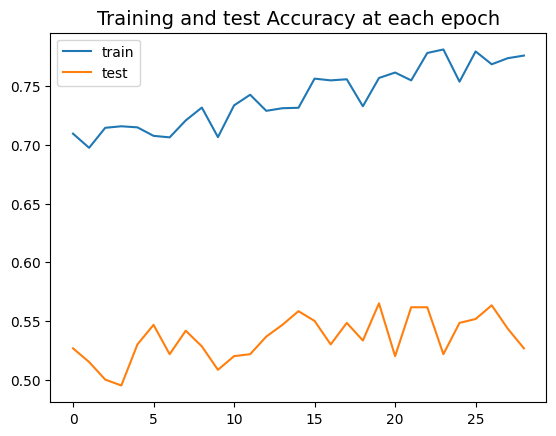

In [30]:
_, train_acc = model.evaluate(X_train_4, y_train_4, verbose=0)
_, test_acc = model.evaluate(X_test_4, y_test_4, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss during training
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Training and test Accuracy at each epoch', fontsize=14)
plt.legend()
plt.show()

In [27]:
# evaluate the model
_, train_acc = model.evaluate(X_train_4, y_train_4, verbose=0)
_, test_acc = model.evaluate(X_test_4, y_test_4, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.698, Test: 0.459


In [ ]:
model2 = Sequential()
model2.add(Dense(512, input_shape=(x_train_glove.shape[1],), activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(7, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

In [ ]:
# Use Pretrained GloVe Model in Neural Network
history2 = model2.fit(x_train_glove, y_train_4, epochs=100, batch_size=64, validation_split=0.1, callbacks=[es])